In [1]:
%pip install proglog

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install sbi

Defaulting to user installation because normal site-packages is not writeable


In [3]:
%pip install moviepy

Defaulting to user installation because normal site-packages is not writeable


In [7]:
%matplotlib inline

In [8]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from moviepy.editor import ImageSequenceClip
from IPython.display import clear_output
import pendulum

# Visualisation of a double pendulum

In [9]:
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t_demo = np.linspace(0, 100, num=1000, dtype=np.float32)
demo_trajectory = pendulum.solve_analytical(x0, t_demo, g=9.8)

In [10]:
L1, L2 = 1, 1
theta1, theta2 = demo_trajectory[:, 0], demo_trajectory[:, 1]
cart_coords = pendulum.radial2cartesian(theta1, theta2, L1, L2)

In [ ]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

images = []
di = 1
N = 100
for i in trange(0, N, di):
  pendulum.make_plot(i, cart_coords, L1, L2, ax)
  images.append(pendulum.fig2image(fig))
plt.close()
ImageSequenceClip(images, fps=25.).ipython_display()

# Prepare a noisy observed trajectory

In [57]:
t = np.linspace(0, 10, num=5, dtype=np.float32)
def sample_trajectories_by_gs(key, gs, noise_std=0.5):
    # odeint is bugged with vmap, probably becouse of the control flow to maintain tolerance
    true_trajectories = jnp.array([pendulum.solve_analytical(x0, t, g=g) for g in gs])
    return true_trajectories + jax.random.normal(key, true_trajectories.shape, true_trajectories.dtype)*noise_std

In [7]:
rng = jax.random.PRNGKey(41231)
rng, subkey = jax.random.split(rng)
observed_trajectory = sample_trajectories_by_gs(subkey, [9.8])

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Classical inference with a likelihood

Run 100 experiments for each proposed value of g

Formulate the likelihood as independent Gaussians centered on each observation

Flat prior: g is uniformy distributed on the grid
$$P(g|x) = \frac{P(x|g)P(g)}{P(x)} = \frac{P(x|g)P(g)}{\sum_g P(x|g)P(g)} = \frac{P(x|g)}{\sum_g P(x|g)}$$

In [47]:
def compute_posterior(key, gs, samples_per_g=100):
    proposed_trajectories = []
    for i in range(samples_per_g):
        key, subkey = jax.random.split(key)
        proposed_trajectories.append(np.expand_dims(sample_trajectories_by_gs(subkey, gs), 1))
    proposed_trajectories = jnp.concatenate(proposed_trajectories, axis=1)
    mu = proposed_trajectories.mean(axis=1)
    sigma = proposed_trajectories.std(axis=1, ddof=1)
    log_L = jax.scipy.stats.norm.logpdf(observed_trajectory, mu, sigma).sum(axis=(1,2))
    # Use numpy for float64 precision
    L = np.exp(np.array(log_L, dtype=np.float64))
    return L / np.sum(L)

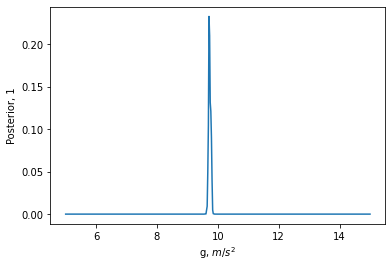

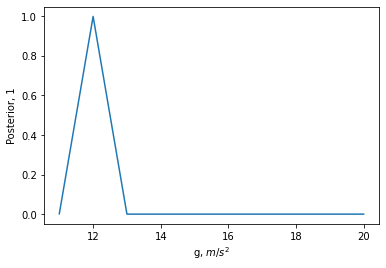

In [48]:
# Note how inference without assumptions is impossible - and by constraining g to a wrong interval, we happyly infer something
for gs in (jnp.linspace(5, 15, num=500, dtype=np.float32),
           jnp.linspace(11, 20, num=10, dtype=np.float32)):
    rng, subkey = jax.random.split(rng)
    posterior = compute_posterior(subkey, gs)
    fig, ax = plt.subplots()
    ax.plot(gs, posterior)
    ax.set_xlabel("g, $m/s^2$")
    ax.set_ylabel("Posterior, 1");

# What if we didn't know the likelihood?

In [95]:
import torch
import sbi
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

In [134]:
# SBI package doesn't support passing the random state, so it has to be taken care of externally
class Simulator:
    def __init__(self, rng_key):
        self.rng_key = rng_key
    
    def simulate(self, gs):
        self.rng_key, subkey = jax.random.split(self.rng_key)
        trajectory = sample_trajectories_by_gs(subkey, jax.numpy.array(gs.ravel(), dtype=jax.numpy.float32))
        return torch.tensor(np.array(trajectory).reshape((gs.shape[0], -1)))

In [135]:
prior = utils.BoxUniform(low=[5], high=[15])
rng, subkey = jax.random.split(rng)
simulator = Simulator(subkey)

In [136]:
inference = SNPE(prior=prior)

In [143]:
# 5 rounds: first round simulates from the prior, second round simulates parameter set 
# that were sampled from the obtained posterior.
num_rounds = 5
# The specific observation we want to focus the inference on.
x_o = torch.tensor(np.array(observed_trajectory.ravel()))

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator.simulate, proposal, num_simulations=100, simulation_batch_size=100)

     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Using SNPE-C with atomic loss
Neural network successfully converged after 47 epochs.

Using SNPE-C with atomic loss
Neural network successfully converged after 33 epochs.

Using SNPE-C with atomic loss
Neural network successfully converged after 27 epochs.

Using SNPE-C with atomic loss
Neural network successfully converged after 60 epochs.

Using SNPE-C with atomic loss
Neural network successfully converged after 33 epochs.


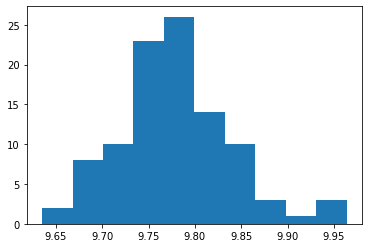

In [152]:
fig, ax = plt.subplots()
plt.hist(posterior.sample((100,), x=x_o).ravel().numpy());

# Task 1: infer the parameters from an unknown trajectory
You are given an "observed" trajectory. It has been simulated with the following function `sample_trajectory_by_params`. Known parameters:
* `m1 = 1` kg
* `l1 = 1` m

Your objective is to infer the distribution of the unknown parameters. They lie in the following intervals:
* `m2` $\in [10^{-2}, 10^{2}]$
* `l2` $\in [10^{-2}, 10^{2}]$
* `g` $\in [10^{-2}, 10^{2}]$
* `noise_std` $\in (0, 1]$

The score is $\log(p_\text{yours}(\text{true params}))$.

In [163]:
def sample_trajectory_by_params(key, params={"m1":1, "m2":1e-2, "l1":1, "l2":1e-2, "g":9.8}, noise_std=0.5):
    # odeint is bugged with vmap, probably becouse of the control flow to maintain tolerance
    true_trajectory = pendulum.solve_analytical(x0, t, **params)
    return true_trajectory + jax.random.normal(key, true_trajectory.shape, true_trajectory.dtype)*noise_std

In [164]:
sample_trajectory_by_params(rng)

DeviceArray([[ 0.44908714,  2.8189435 , -0.08292126, -0.21967202],
             [ 0.7204919 ,  0.6912546 , -2.5740802 , 14.793001  ],
             [ 0.3729041 ,  0.756153  , -3.8830612 , -8.304898  ],
             [-1.1505558 , -0.26385248, -3.250876  , 20.278803  ],
             [-1.1523098 , -0.4603747 , -1.898539  ,  4.320295  ]],            dtype=float32)